In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.data_loader import load_stock_data, split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.cointegration import CointegrationModel
from strategies.cointegrationtrading import CointegrationTrader
from utils.visualization import plot_cointegration_trade

In [3]:
os.makedirs("results", exist_ok=True)

data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)

try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Chargement des données à partir de data\jse_stocks.csv...
(2616, 45)
Informations sectorielles chargées pour 45 actions


In [4]:
train_data, test_data = split_data(prices, train_ratio=0.7)
print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data, significance_level=0.01)

print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées sur toute la période disponible")


Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 44 paires co-intégrées sur toute la période disponible



Analyse de la paire 1: RMH.JO - KIO.JO (p-value: 0.000026)
  Secteurs: RMH.JO (Financials), KIO.JO (Industrials)
  Même secteur: Non

Analyse de la paire 2: AGL.JO - RMH.JO (p-value: 0.000049)
  Secteurs: AGL.JO (Resources), RMH.JO (Financials)
  Même secteur: Non

Analyse de la paire 3: VKE.JO - RLO.JO (p-value: 0.000072)
  Secteurs: VKE.JO (Property), RLO.JO (Construction)
  Même secteur: Non

Analyse de la paire 4: NPN.JO - REM.JO (p-value: 0.000077)
  Secteurs: NPN.JO (Technology), REM.JO (Consumer)
  Même secteur: Non

Analyse de la paire 5: AVI.JO - WBO.JO (p-value: 0.000207)
  Secteurs: AVI.JO (Industrials), WBO.JO (Construction)
  Même secteur: Non


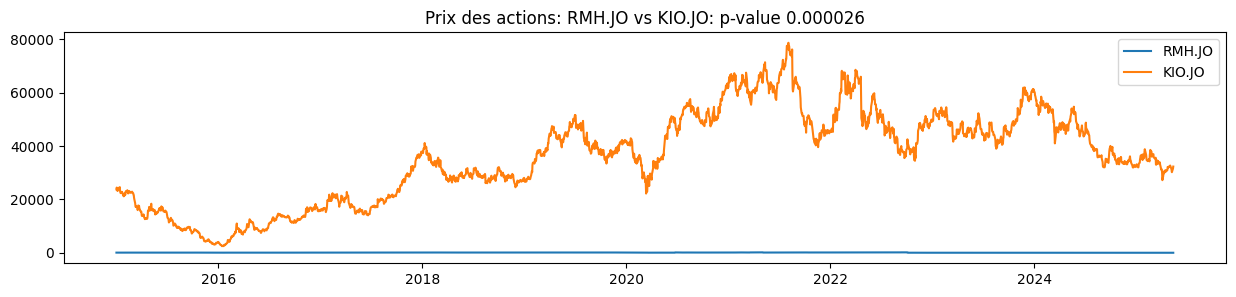

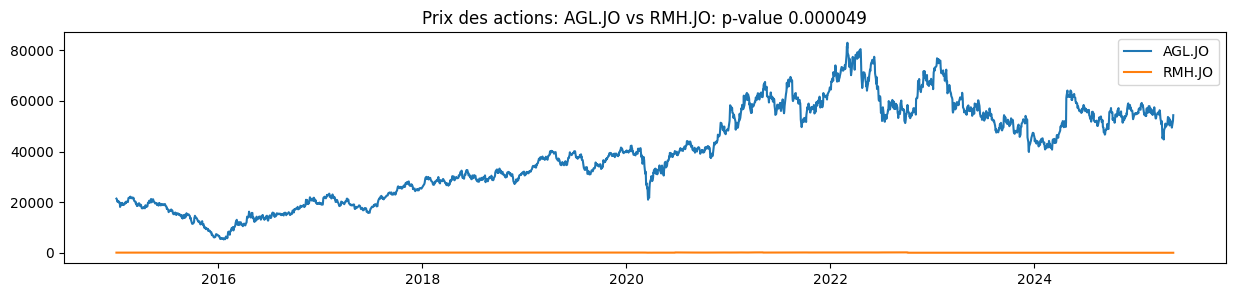

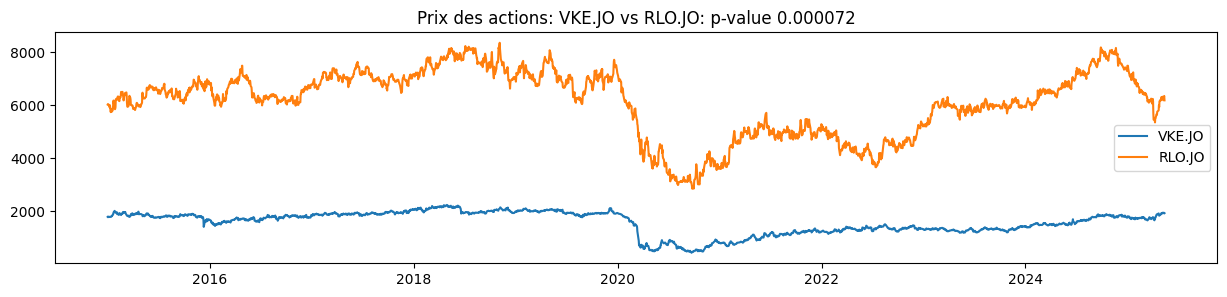

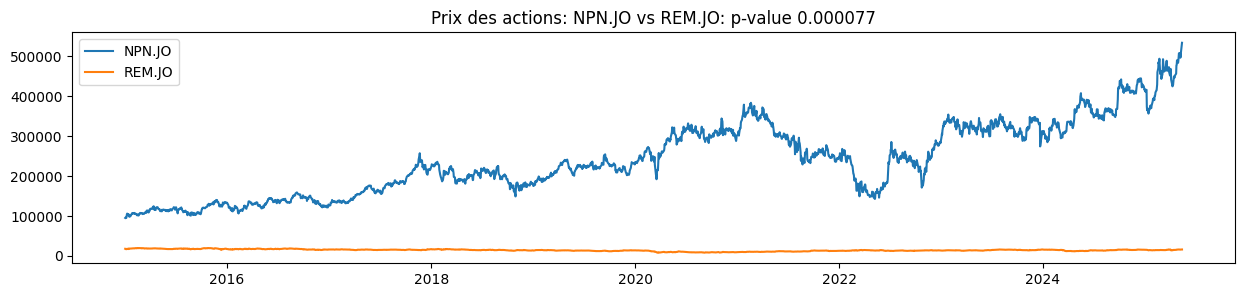

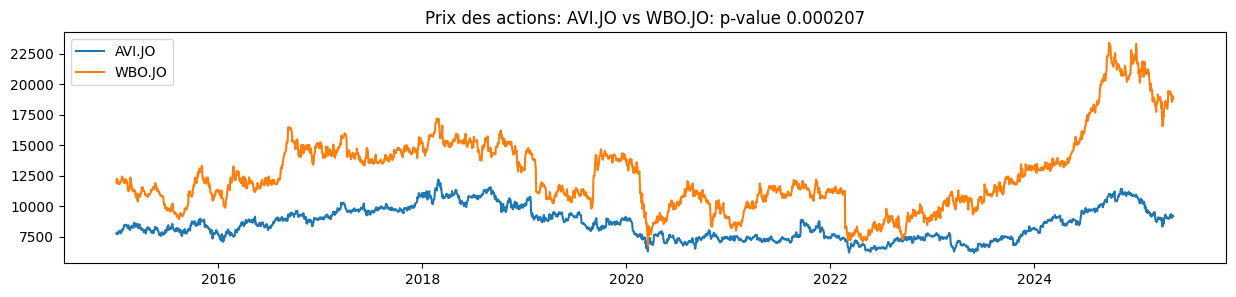

In [5]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(prices[ticker1], label=ticker1)
    plt.plot(prices[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()


Analyse de la paire 1: RMH.JO - KIO.JO (p-value: 0.000026)
  Secteurs: RMH.JO (Financials), KIO.JO (Industrials)
  Même secteur: Non
  Performance: Rendement total: 1.8012, Sharpe: 0.3767, Trades: 46


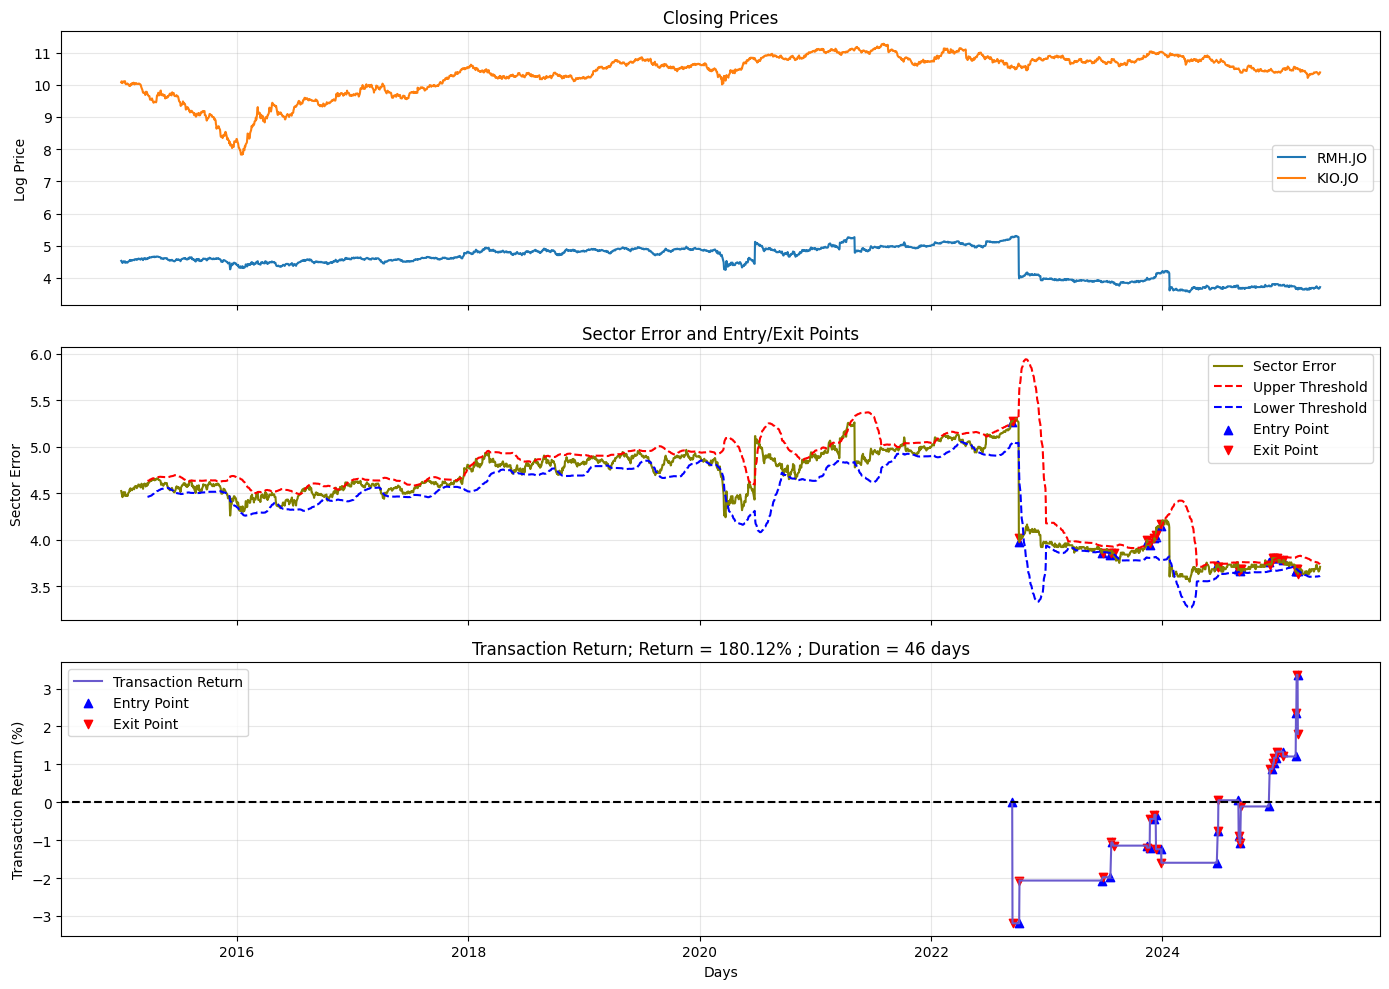


Analyse de la paire 2: AGL.JO - RMH.JO (p-value: 0.000049)
  Secteurs: AGL.JO (Resources), RMH.JO (Financials)
  Même secteur: Non
  Performance: Rendement total: -7848.7037, Sharpe: -1.4855, Trades: 18


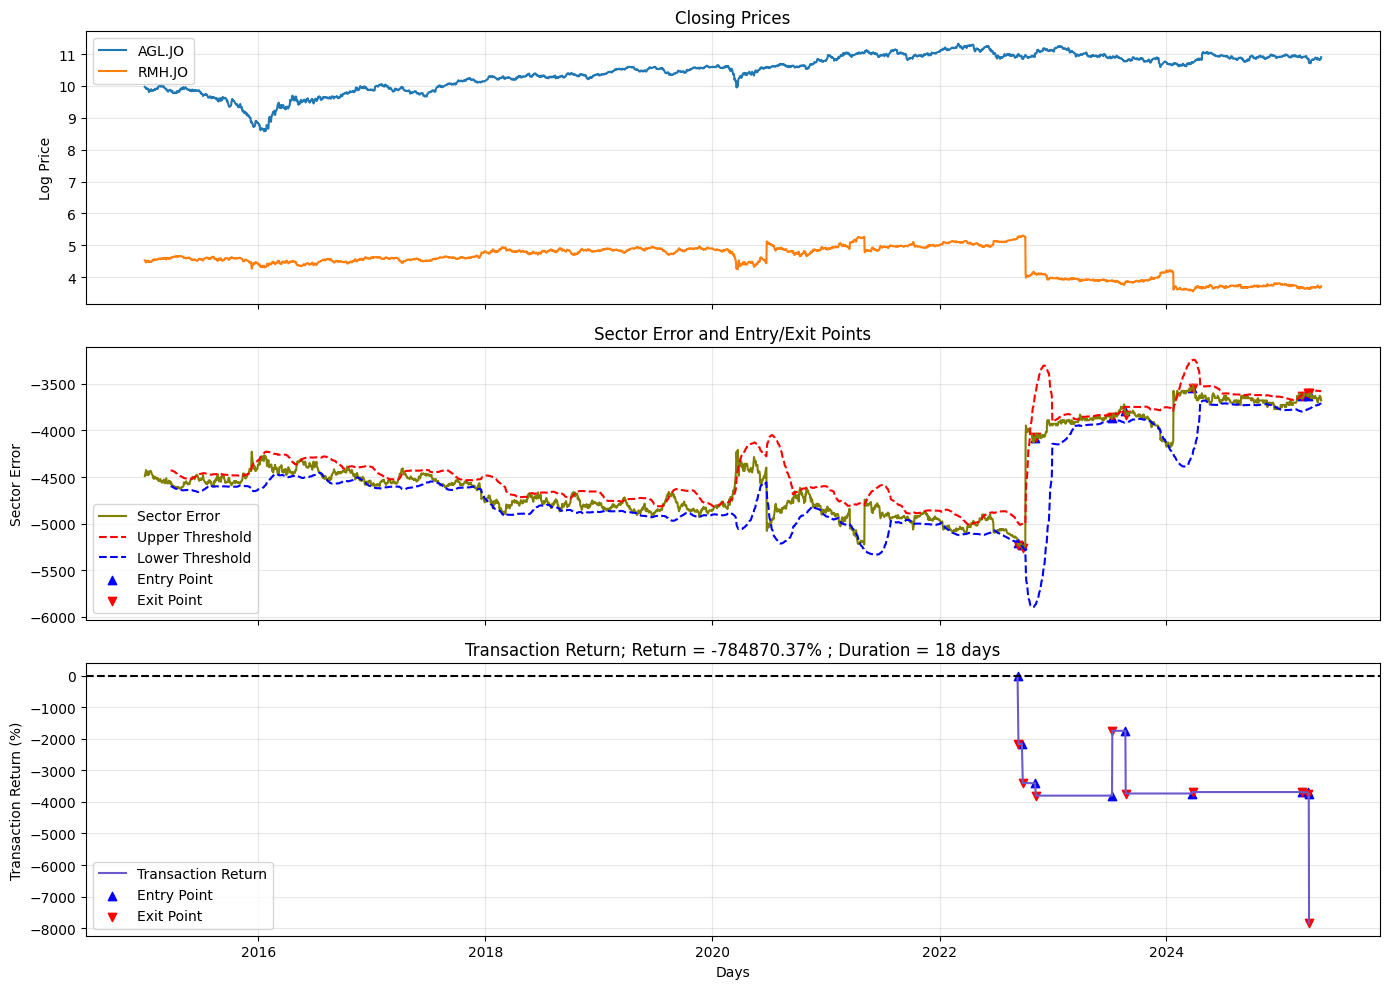


Analyse de la paire 3: VKE.JO - RLO.JO (p-value: 0.000072)
  Secteurs: VKE.JO (Property), RLO.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 62.2654, Sharpe: 0.4947, Trades: 38


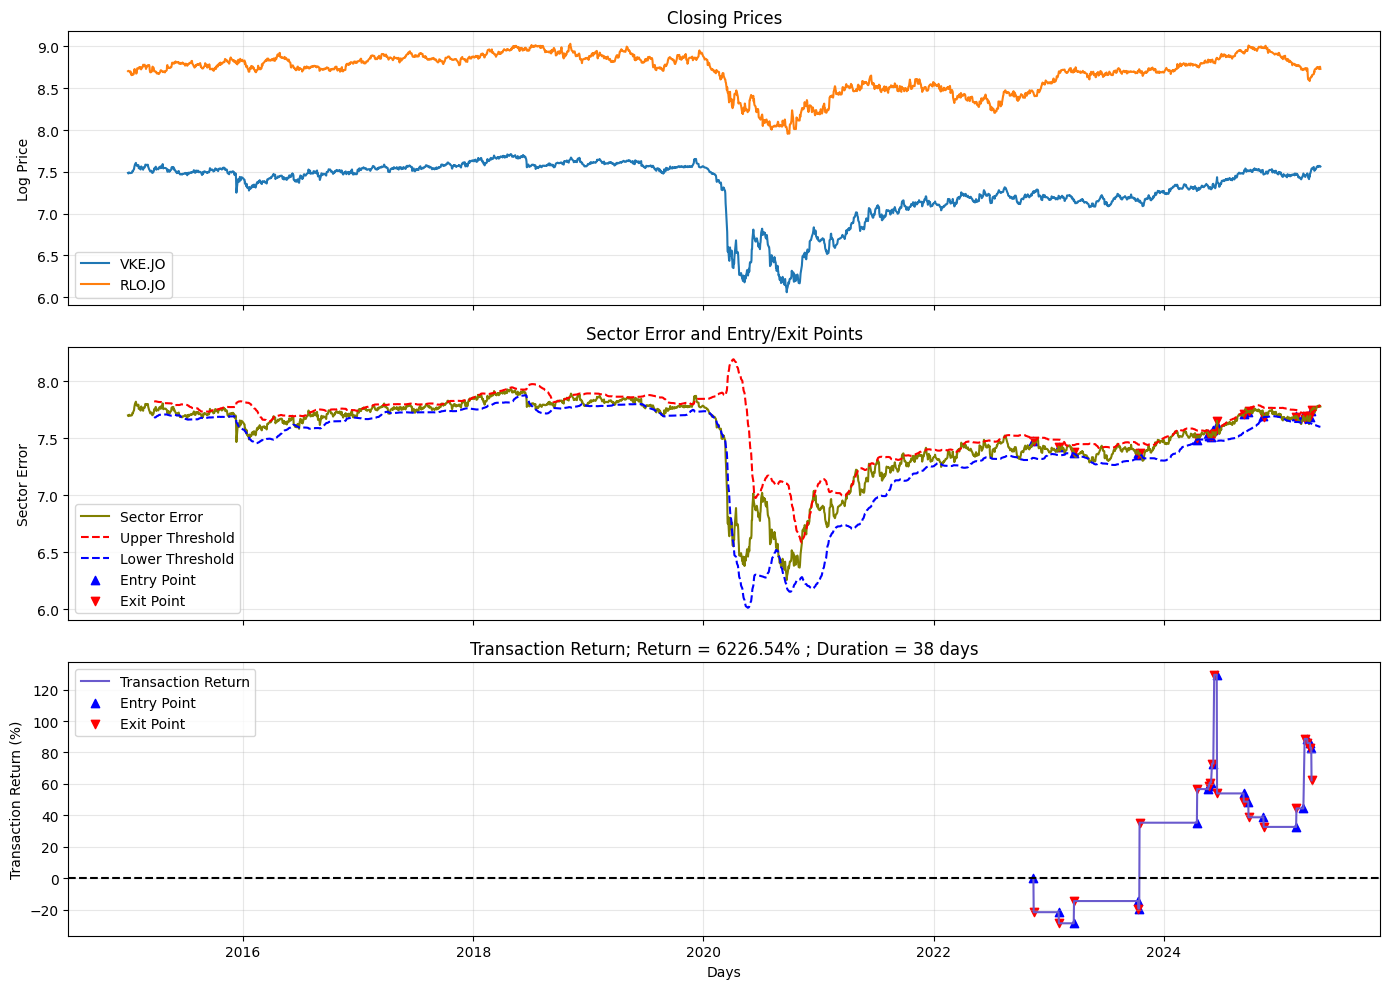


Analyse de la paire 4: NPN.JO - REM.JO (p-value: 0.000077)
  Secteurs: NPN.JO (Technology), REM.JO (Consumer)
  Même secteur: Non
  Performance: Rendement total: 12372.8987, Sharpe: 0.3742, Trades: 22


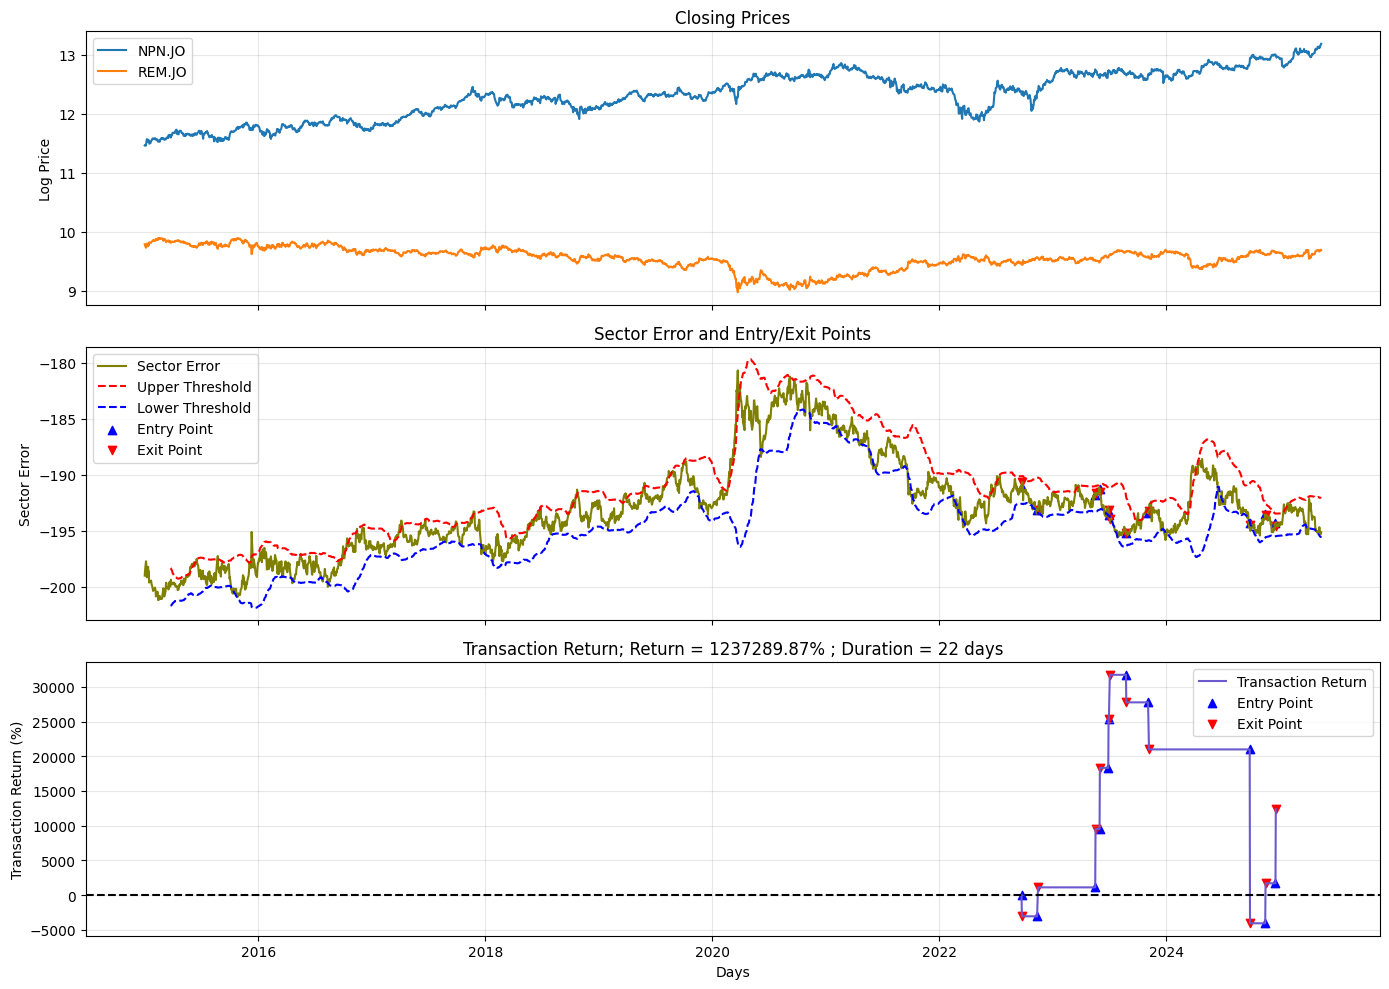


Analyse de la paire 5: AVI.JO - WBO.JO (p-value: 0.000207)
  Secteurs: AVI.JO (Industrials), WBO.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 811.9760, Sharpe: 1.0311, Trades: 48


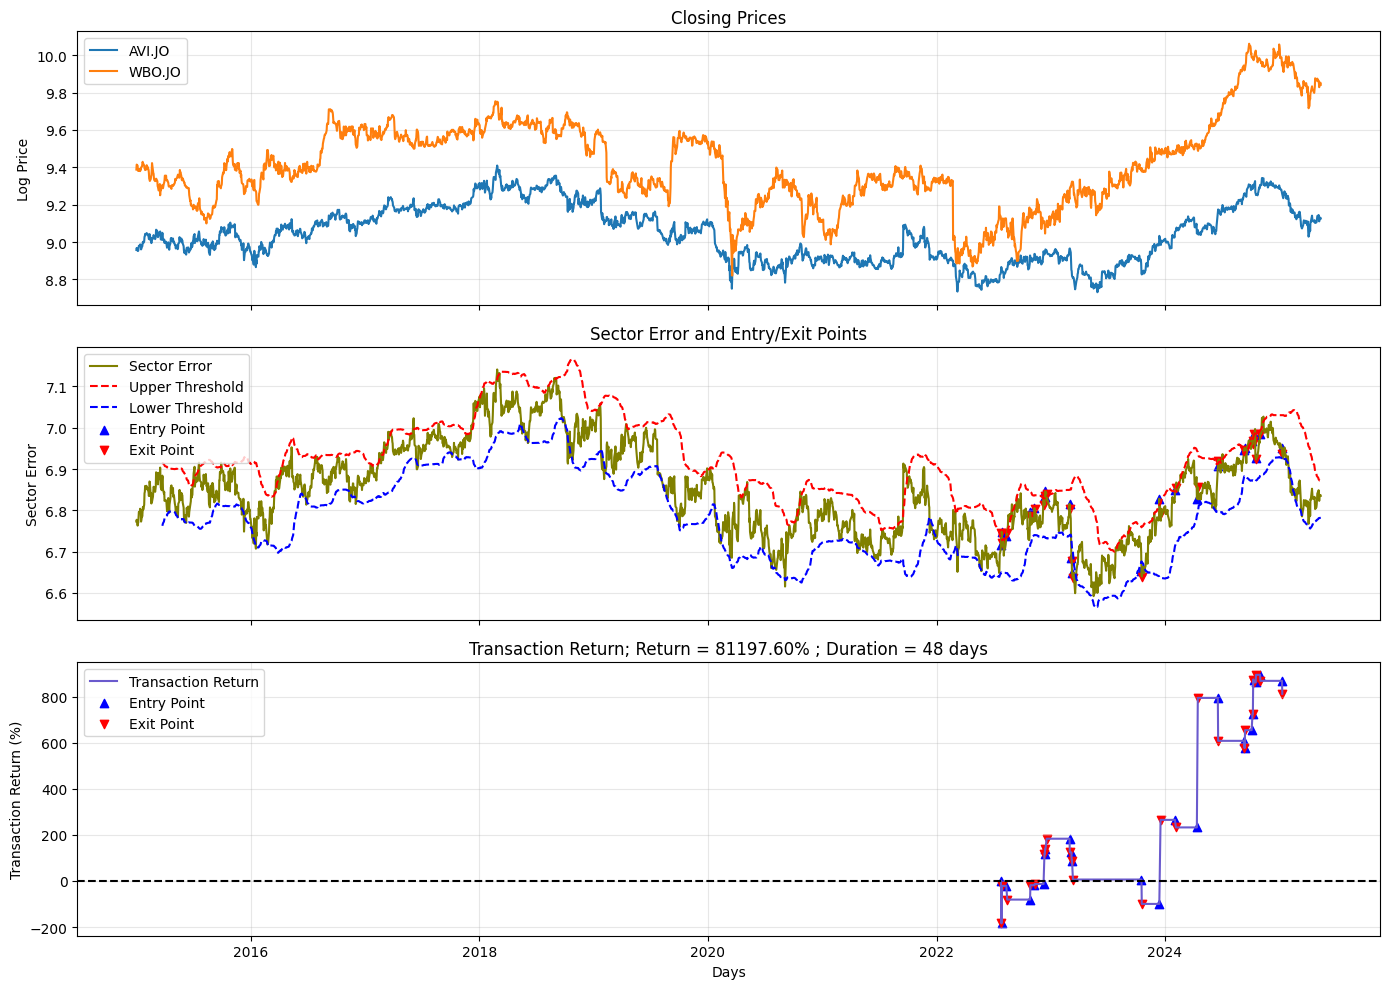

In [6]:
for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    model = CointegrationModel(significance_level=0.05)

    trader = CointegrationTrader(
    model,
    entry_threshold=2.0,
    stop_loss=0.05,
    profit_target=0.05,
    rolling_window=60
)


    trades = trader.run_backtest(
        test_data[ticker1], test_data[ticker2]
    )

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values
    sharpe = (
        np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
        if len(pnl_values) >= 2 and np.std(pnl_values) > 0
        else 0
    )

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    
    plot_cointegration_trade(
        prices=prices,
        ticker1=ticker1,
        ticker2=ticker2,
        trades=trades,
        beta=model.beta,
        entry_threshold=2.0
    )

In [7]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    trades = trader.run_backtest(
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )

# print total pnl and mean pnl
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Analyse de la paire 1: RMH.JO - KIO.JO (p-value: 0.000026)
  Performance: Rendement total: 1.8012, Sharpe: 0.3767, Trades: 46

Analyse de la paire 2: AGL.JO - RMH.JO (p-value: 0.000049)
  Performance: Rendement total: -7848.7037, Sharpe: -1.4855, Trades: 18

Analyse de la paire 3: VKE.JO - RLO.JO (p-value: 0.000072)
  Performance: Rendement total: 62.2654, Sharpe: 0.4947, Trades: 38

Analyse de la paire 4: NPN.JO - REM.JO (p-value: 0.000077)
  Performance: Rendement total: 12372.8987, Sharpe: 0.3742, Trades: 22

Analyse de la paire 5: AVI.JO - WBO.JO (p-value: 0.000207)
  Performance: Rendement total: 811.9760, Sharpe: 1.0311, Trades: 48

Analyse de la paire 6: SPP.JO - GRT.JO (p-value: 0.000408)
  Performance: Rendement total: -879.1421, Sharpe: -0.9363, Trades: 14

Analyse de la paire 7: SPP.JO - RDF.JO (p-value: 0.000418)
  Performance: Rendement total: -283.1786, Sharpe: -0.2313, Trades: 24

Analyse de la paire 8: SPP.JO - RLO.JO (p-value: 0.000494)
  Performance: Rendement total:

c:\Users\emmae\OneDrive\Documents\M2\S2\Kalman-Filtering-Applied-to-Investment-Portfolio-Management\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\emmae\OneDrive\Documents\M2\S2\Kalman-Filtering-Applied-to-Investment-Portfolio-Management\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\emmae\OneDrive\Documents\M2\S2\Kalman-Filtering-Applied-to-Investment-Portfolio-Management\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\emmae\OneDrive\Documents\M2\S2\Kalman-Filtering-Applied-to-Investment-Portfolio-Management\.venv\Lib\site-packages\statsmodels\regression\l


Analyse de la paire 22: MUR.JO - RLO.JO (p-value: 0.003143)
  Performance: Rendement total: -267.5853, Sharpe: -2.4350, Trades: 52

Analyse de la paire 23: MNP.JO - NTC.JO (p-value: 0.003355)
  Performance: Rendement total: 5711.4188, Sharpe: 2.4344, Trades: 32

Analyse de la paire 24: MNP.JO - KIO.JO (p-value: 0.003406)
  Performance: Rendement total: 3066.4226, Sharpe: 1.3800, Trades: 26

Analyse de la paire 25: RMH.JO - BTI.JO (p-value: 0.004107)
  Performance: Rendement total: -2.0174, Sharpe: -0.4646, Trades: 38

Analyse de la paire 26: MNP.JO - NPN.JO (p-value: 0.004114)
  Performance: Rendement total: 465.4926, Sharpe: 0.3590, Trades: 20

Analyse de la paire 27: MNP.JO - WHL.JO (p-value: 0.004215)
  Performance: Rendement total: -2198.9254, Sharpe: -1.1271, Trades: 26

Analyse de la paire 28: VOD.JO - BTI.JO (p-value: 0.004709)
  Performance: Rendement total: 10602.6009, Sharpe: 1.1043, Trades: 28

Analyse de la paire 29: ANG.JO - SOL.JO (p-value: 0.005093)
  Performance: Rende